<img src="Aerolineas Europa 2025.jpg" width="50%" alt="Portada">

#### Importaciones

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importar modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

#### Carga de datos 

In [14]:
df = pd.read_csv('train_limpio.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Genero                                 103904 non-null  int64  
 1   Edad                                   103904 non-null  int64  
 2   Tipo de viaje                          103904 non-null  int64  
 3   Clase                                  103904 non-null  int64  
 4   Distancia del vuelo                    103904 non-null  int64  
 5   Servicio wifi a bordo                  103904 non-null  int64  
 6   Horario de salida/llegada conveniente  103904 non-null  int64  
 7   Facilidad para reservar online         103904 non-null  int64  
 8   Comida y bebida                        103904 non-null  int64  
 9   Embarque online                        103904 non-null  int64  
 10  Comodidad del asiento                  103904 non-null  

Columna = "Retraso en la llegada en minutos":        310 nulos - "0.3%"

### Cantidad de pasajeros satisfechos & insatisfechos

In [16]:
df['Satisfacción'].value_counts()

Satisfacción
0    58879
1    45025
Name: count, dtype: int64

#### Eliminar los nulos de la columna "Retraso en la llegada en minutos"

In [17]:
print("Tamaño antes de eliminar nulos:", df.shape)

df.dropna(inplace=True)

print("Tamaño después de eliminar nulos:", df.shape)

Tamaño antes de eliminar nulos: (103904, 20)
Tamaño después de eliminar nulos: (103594, 20)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Genero                                 103594 non-null  int64  
 1   Edad                                   103594 non-null  int64  
 2   Tipo de viaje                          103594 non-null  int64  
 3   Clase                                  103594 non-null  int64  
 4   Distancia del vuelo                    103594 non-null  int64  
 5   Servicio wifi a bordo                  103594 non-null  int64  
 6   Horario de salida/llegada conveniente  103594 non-null  int64  
 7   Facilidad para reservar online         103594 non-null  int64  
 8   Comida y bebida                        103594 non-null  int64  
 9   Embarque online                        103594 non-null  int64  
 10  Comodidad del asiento                  103594 non-null  int64

#### Establecer la y= target 

In [19]:
X = df.drop(columns= ['Satisfacción'])
y = df['Satisfacción']

#### Dividir en Train y Test 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Escalar los datos

In [21]:
# Escalar los datos (StandardScaler)

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape", X_train_scaled.shape)
print("Test shape", X_test_scaled.shape)

Train shape (82875, 19)
Test shape (20719, 19)


## Modelos

### Logistic Regresion / Regresión Logística

In [22]:
lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Accuracy: 0.8581495245909552


In [29]:
# Definir parámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Configurar GridSearch
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar
print("Entrenando Grid Search para Regresión Logística...")
grid_lr.fit(X_train_scaled, y_train)

# Resultados
best_lr = grid_lr.best_estimator_
y_pred_lr_opt = best_lr.predict(X_test_scaled)
print(f"Mejores parámetros (LR): {grid_lr.best_params_}")
print(f"Accuracy en Test (LR): {accuracy_score(y_test, y_pred_lr_opt):.4f}")

Entrenando Grid Search para Regresión Logística...
Mejores parámetros (LR): {'C': 0.1, 'solver': 'liblinear'}
Accuracy en Test (LR): 0.8581


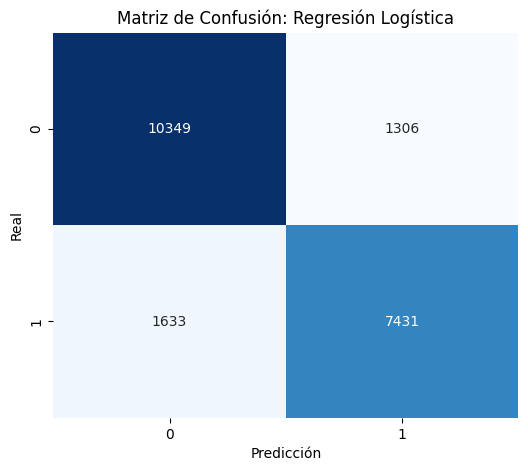

In [43]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Decision Tree (Árbol de Decisión)

In [53]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train) 

y_pred_dt = dt.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

Accuracy: 0.9385105458757662


In [79]:
# Definir parámetros
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearch
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar

grid_dt.fit(X_train_scaled, y_train)

# Resultados
best_dt = grid_dt.best_estimator_
y_pred_dt_opt = best_dt.predict(X_test_scaled)
print(f"Mejores parámetros (DT): {grid_dt.best_params_}")
print(f"Accuracy en Test (DT): {accuracy_score(y_test, y_pred_dt_opt):.4f}")

Mejores parámetros (DT): {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}
Accuracy en Test (DT): 0.9416


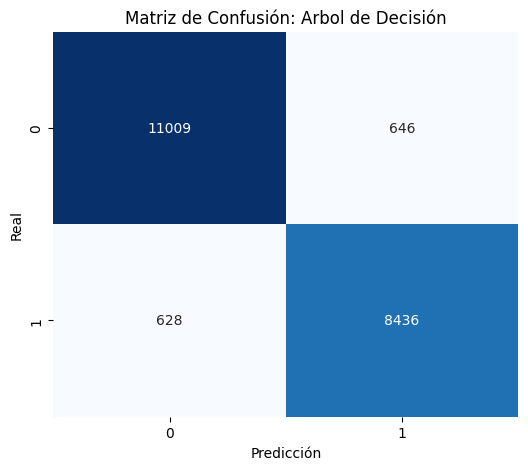

In [54]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_dt)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Arbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Random Forest

In [70]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.9563685506057242


In [84]:
# Definir parámetros
# Nota: Random Forest puede tardar, he puesto rangos razonables.
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 4]
}

# Configurar GridSearch
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3, # Bajamos cv a 3 para agilizar
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar

grid_rf.fit(X_train_scaled, y_train)

# Resultados
best_rf = grid_rf.best_estimator_
y_pred_rf_opt = best_rf.predict(X_test_scaled)
print(f"Mejores parámetros (RF): {grid_rf.best_params_}")
print(f"Accuracy en Test (RF): {accuracy_score(y_test, y_pred_rf_opt):.4f}")

Mejores parámetros (RF): {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Accuracy en Test (RF): 0.9567


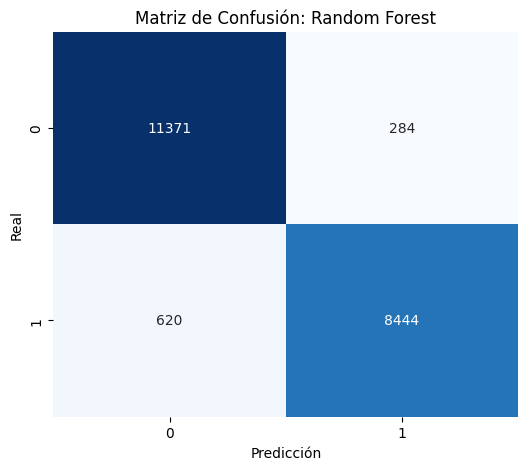

In [56]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### Gradient Boosting

In [74]:
gb = GradientBoostingClassifier(random_state=42, learning_rate = 0.2)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

Accuracy: 0.9420338819441093


In [ ]:
param_grid = {'n_estimators': [100, 200],      # Más árboles suelen mejorar el rendimiento
              'learning_rate': [0.05, 0.1, 0.2], # Probamos bajar la velocidad
              'max_depth': [3, 5]}

# Configurar GridSearch (cv=5 para ser robustos)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search_gb.fit(X_train_scaled, y_train)

# Resultados
print(f"Mejor Accuracy tras tuning: {grid_search_gb.best_score_:.4f}")
print(f"Mejores parámetros: {grid_search_gb.best_params_}")

# Comparar con el Test Set final
best_gb = grid_search_gb.best_estimator_
print(f"Test Set Accuracy final: {best_gb.score(X_test_scaled, y_test):.4f}")

Mejor Accuracy tras tuning: 0.9548
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Test Set Accuracy final: 0.9554


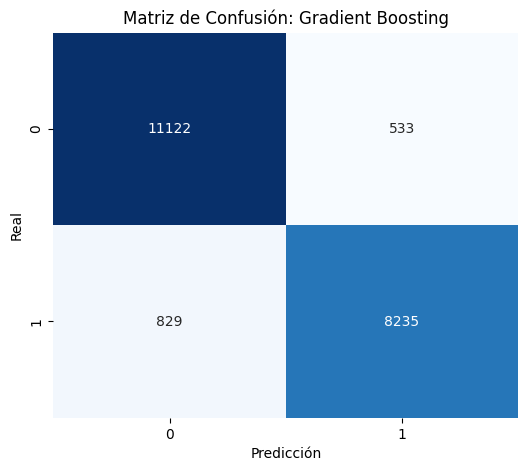

In [59]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_gb)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Gradient Boosting')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

## XGBoost

In [26]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Entrenar
xgb.fit(X_train_scaled, y_train)

# Predecir
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluar
print("Accuracy (XGBoost base):", accuracy_score(y_test, y_pred_xgb))

c:\Users\mikel\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:08:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost base): 0.956802934504561


In [27]:
# Definir parámetros para GridSearch
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 6]}

# Configurar GridSearch
grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    cv=3,                
    scoring='accuracy',  
    n_jobs=-1)

# Entrenar (esto puede tardar un poco)

grid_xgb.fit(X_train_scaled, y_train)

# Resultados
best_xgb = grid_xgb.best_estimator_
y_pred_xgb_opt = best_xgb.predict(X_test_scaled)

print(f"Mejores parámetros (XGB): {grid_xgb.best_params_}")
print(f"Accuracy en Test (XGB Optimizado): {accuracy_score(y_test, y_pred_xgb_opt):.4f}")

c:\Users\mikel\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:09:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros (XGB): {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}
Accuracy en Test (XGB Optimizado): 0.9588


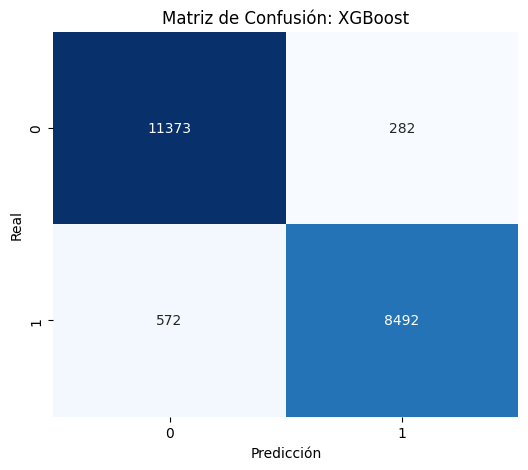

In [28]:
# Crear matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb_opt)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### KNN (K-Nearest Neighbors)

In [61]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

Accuracy: 0.9234519040494232


In [85]:
# Definir parámetros
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2] # 1=Manhattan, 2=Euclidean
}

# Configurar GridSearch
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar (KNN puede ser lento en inferencia con muchos datos)
print("Entrenando Grid Search para KNN...")
grid_knn.fit(X_train_scaled, y_train)

# Resultados
best_knn = grid_knn.best_estimator_
y_pred_knn_opt = best_knn.predict(X_test_scaled)
print(f"Mejores parámetros (KNN): {grid_knn.best_params_}")
print(f"Accuracy en Test (KNN): {accuracy_score(y_test, y_pred_knn_opt):.4f}")

Entrenando Grid Search para KNN...
Mejores parámetros (KNN): {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Accuracy en Test (KNN): 0.9358


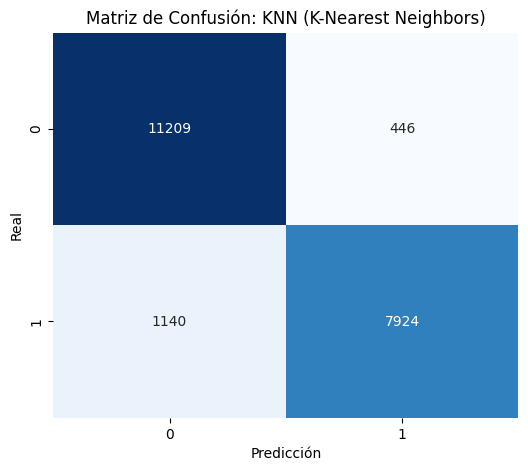

In [63]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_knn)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: KNN (K-Nearest Neighbors)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### SVC (Support Vector Classifier)

In [65]:
svc = SVC(probability=True, random_state=42)


svc.fit(X_train_scaled[:10000], y_train[:10000])

y_pred_svc = svc.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred_svc))

Accuracy: 0.9361455668709879


In [87]:
# Definir parámetros
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Configurar GridSearch
grid_svc = GridSearchCV(
    SVC(random_state=42),
    param_grid_svc,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Entrenar usando SOLO una submuestra (ej. 5000 filas) por eficiencia

grid_svc.fit(X_train_scaled[:5000], y_train[:5000])

# Resultados (Evaluamos en todo el test set)
best_svc = grid_svc.best_estimator_
y_pred_svc_opt = best_svc.predict(X_test_scaled)
print(f"Mejores parámetros (SVC): {grid_svc.best_params_}")
print(f"Accuracy en Test (SVC): {accuracy_score(y_test, y_pred_svc_opt):.4f}")

Mejores parámetros (SVC): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy en Test (SVC): 0.9292


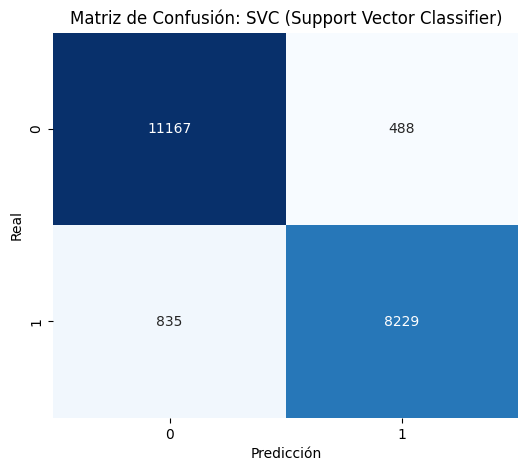

In [66]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_svc)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: SVC (Support Vector Classifier)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#### KMeans (Clustering - No Supervisado)

In [67]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

y_pred_kmeans = kmeans.predict(X_test_scaled)


acc = accuracy_score(y_test, y_pred_kmeans)
if acc < 0.5:
    y_pred_kmeans = 1 - y_pred_kmeans 
    acc = accuracy_score(y_test, y_pred_kmeans)

print("Accuracy estimada:", acc)

Accuracy estimada: 0.7598822336985376


In [88]:
# Definir parámetros
# Fijamos n_clusters=2 porque sabemos que la salida es binaria (Satisfacción 0 o 1)
param_grid_km = {
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]
}

# Configurar GridSearch
# Nota: KMeans no usa 'accuracy' en scoring por defecto, usa inercia negativa.
grid_km = GridSearchCV(
    KMeans(n_clusters=2, random_state=42),
    param_grid_km,
    cv=3,
    n_jobs=-1
)

# Entrenar
print("Entrenando Grid Search para KMeans...")
grid_km.fit(X_train_scaled)

# Obtener el mejor modelo
best_km = grid_km.best_estimator_
print(f"Mejores parámetros (KMeans): {grid_km.best_params_}")

# Predecir y calcular Accuracy manualmente (invirtiendo etiquetas si es necesario)
y_pred_km_opt = best_km.predict(X_test_scaled)

acc_km = accuracy_score(y_test, y_pred_km_opt)
if acc_km < 0.5:
    y_pred_km_opt = 1 - y_pred_km_opt # Invertir 0s y 1s
    acc_km = accuracy_score(y_test, y_pred_km_opt)

print(f"Accuracy estimada en Test (KMeans): {acc_km:.4f}")

Entrenando Grid Search para KMeans...
Mejores parámetros (KMeans): {'init': 'k-means++', 'max_iter': 300, 'n_init': 20}
Accuracy estimada en Test (KMeans): 0.7606


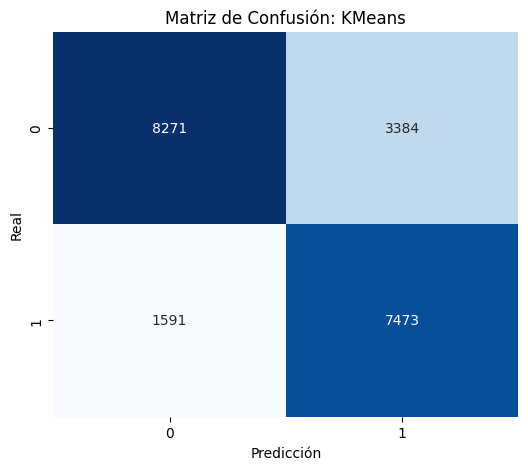

In [68]:
# Crear matriz de confusión
cm = confusion_matrix(y_test, y_pred_kmeans)

# Visualización gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: KMeans')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
# Elegimos el mejor modelo según resultados (Random Forest)
mejor_modelo = model_rf 


# Guardar el modelo entrenado
with open('mejor_modelo.pkl', 'wb') as f:
    pickle.dump(mejor_modelo, f)

# IMPORTANTE: Guardar también el escalador (scaler)
# Si no escalas los datos nuevos igual que los de entrenamiento, el modelo fallará.
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# 1. Importar XGBoost
from xgboost import XGBClassifier

# 2. Instanciar el modelo
# XGBoost maneja los 'NaN' internamente por defecto.
xgb = XGBClassifier(random_state=42)

# 3. Entrenar
# IMPORTANTE: Usamos X_train directamente (NO X_train_scaled)
# porque si hay nulos reales, el StandardScaler fallaría.
xgb.fit(X_train, y_train)

# 4. Predecir
y_pred_xgb = xgb.predict(X_test)

# 5. Evaluar
print("Accuracy XGBoost:", accuracy_score(y_test, y_pred_xgb))
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred_xgb))

Accuracy XGBoost: 0.9560175160001925

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11713
           1       0.96      0.94      0.95      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.95      0.96     20781
weighted avg       0.96      0.96      0.96     20781

